In [1]:
from typing import List, Dict, Any , Optional
from pydantic import BaseModel, Field

# LangGraph core
from langgraph.graph import StateGraph, END
from langgraph.types import StreamWriter
from langgraph.prebuilt import ToolNode

# LangChain core types
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, BaseMessage
from langchain_core.tools import tool

# Project deps (adjust imports if your package layout differs)
from backend.state import State
from backend.client import get_llm, get_vectorstore
from backend.settings import app_settings
from backend.assets.toc_data import toc
from backend.drawing_nodes import page_locator_llm, url_from_blob

# Azure Search (used by your drawing URL resolver)
from azure.search.documents import SearchClient
from azure.core.credentials import AzureKeyCredential

import json, uuid, time
from types import SimpleNamespace

from typing import Sequence
from typing_extensions import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langgraph.managed import RemainingSteps

llm = get_llm()
print("Imports OK")


c:\Users\yasha\OneDrive\Desktop\ai\maintenance-assistant\.venv\Lib\site-packages\pydantic_settings\main.py:188: UserWarning: A custom validator is returning a value other than `self`.
Returning anything other than `self` from a top level model validator isn't supported when validating via `__init__`.
See the `model_validator` docs (https://docs.pydantic.dev/latest/concepts/validators/#model-validators) for more details.
  super().__init__(
c:\Users\yasha\OneDrive\Desktop\ai\maintenance-assistant\backend\settings.py:235: UserWarning: A custom validator is returning a value other than `self`.
Returning anything other than `self` from a top level model validator isn't supported when validating via `__init__`.
See the `model_validator` docs (https://docs.pydantic.dev/latest/concepts/validators/#model-validators) for more details.
  super().__init__(**data)
DEBUG:root:Using Azure Cognitive Search


Imports OK


In [2]:
class MyAgentState(TypedDict):
    # REQUIRED by create_react_agent
    messages: Annotated[Sequence[BaseMessage], add_messages]
    remaining_steps: RemainingSteps

    hits: List[Dict[str, Any]]   # set by tool_troubleshoot
    pages: List[int]             # set by tool_find_drawing

In [7]:
class TroubleshootArgs(BaseModel):
    query: str = Field(..., description="Technician troubleshooting query")

class DrawingArgs(BaseModel):
    query: str = Field(..., description="Drawing/table/BOM request")

class PagesArgs(BaseModel):
    pages: List[int] = Field(..., description="BOM start pages to resolve to URLs")

class MissingArgs(BaseModel):
    query: str = Field(..., description="Raw text to scan for critical troubleshooting signals")


In [14]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

config = {"configurable": {"thread_id": "demo-thread-003"}}


In [4]:
from langchain_core.messages import SystemMessage

domain = "mechanical maintenance"
tone = "helpful, expert, friendly, professional"
tools = ['tool_troubleshoot', 'tool_find_drawing', 'tool_get_drawing_urls']

rules = [
    f"You are a {domain} assistant. \n",
    f"Respond in a {tone} manner.",
    "Always answer the MOST RECENT user message; use prior turns for context. \n",
    # Tool routing policy for your notebook tools:
    f""" 
    TOOLS:
    ------

    You have access to the following tools:

    {tools}\n
    "- DRAWINGS: Call tool_find_drawing first; if it returns pages, then call tool_get_drawing_urls.\n"
    "- TROUBLESHOOT: Call tool_troubleshoot to get relevant documents for any troubleshooting query.\n"

    To use a tool, please use the following format:

    ```
    Thought: Do I need to use a tool? Yes
    Action: the action to take, should be one of [{tools}]
    Action Input: the input to the action
    Observation: the result of the action
    ```

    When you have a response to say to the Human, or if you do not need to use a tool, you MUST use the format:

    ```
    Thought: Do I need to use a tool? No
    Final Answer: [your response here]
    ```

    Begin!

    conversation history: \n
    """,
]


prompt =  SystemMessage(content="\n".join(rules))


In [8]:
@tool("tool_troubleshoot", args_schema=TroubleshootArgs)
def tool_troubleshoot(query: str) -> Dict[str, Any]:
    """
    retrieve docs (hybrid). Returns observations only.
    """
    vs = get_vectorstore()
    retriever = vs.as_retriever(search_type="hybrid", k=8)

    docs = retriever.get_relevant_documents(query)

    return {
        "docs": [getattr(d, "page_content", "") for d in docs],
        "metas": [getattr(d, "metadata", {}) for d in docs],
    }

print("tool_troubleshoot ready")


tool_troubleshoot ready


In [ ]:
@tool("tool_find_drawing", args_schema=DrawingArgs)
def tool_find_drawing(query: str) -> Dict[str, Any]:
    """
    Use TOC-aware locator to find candidate BOM start pages.
    If ambiguous, return clarification_needed with candidates.
    """
    
    system = SystemMessage(content=(
        "You have a BOM table-of-contents. Follow strict validity rules and ambiguity handling.\n"
        "Respond using PagePredictResponse (pages/answer/clarification_needed)."
    ))
    user = HumanMessage(content=f"TOC:\n{toc}\n\nUSER QUERY:\n{query}")
    result = page_locator_llm.invoke([system, user])

    out: Dict[str, Any] = {"rewritten": query}

    if getattr(result, "clarification_needed", False) or getattr(result, "answer", None):
        out["clarification_needed"] = True
        out["answer"] = getattr(result, "answer", "")
        out["candidates"] = getattr(result, "pages", []) or []
        return out

    pages, seen = [], set()
    for p in (getattr(result, "pages", None) or []):
        if isinstance(p, int) and p not in seen:
            pages.append(p); seen.add(p)
    out["pages"] = pages
    return out

print("tool_find_drawing ready")


tool_find_drawing ready


In [10]:
@tool("tool_get_drawing_urls", args_schema=PagesArgs)
def tool_get_drawing_urls(pages: List[int]) -> Dict[str, Any]:
    """
    Resolve BOM pages -> blob SAS URLs + citation objects.
    """
    search_client = SearchClient(
        endpoint=app_settings.azure_search_credentials.endpoint,
        index_name=app_settings.azure_search_credentials.index,
        credential=AzureKeyCredential(app_settings.azure_search_credentials.key),
    )

    citations, urls = [], []
    for p in pages:
        doc_id = f"Husky_2_Mechanical_Drawing_Package-p{p}"
        raw = search_client.get_document(key=doc_id)
        metadata = json.loads(raw["metadata"])
        blob = metadata.get("blob_name")
        page = metadata.get("page")
        if blob:
            url = url_from_blob(blob)
            urls.append(url)
            if page is not None:
                citations.append({"title": f"Page {page}", "url": url})

    return {"urls": urls, "citations": citations}

print("tool_get_drawing_urls ready")


tool_get_drawing_urls ready


In [11]:
TOOLS = [
    tool_troubleshoot,
    tool_find_drawing,
    tool_get_drawing_urls,
]
tools = [t.name for t in TOOLS]
print([t.name for t in TOOLS])


['tool_troubleshoot', 'tool_find_drawing', 'tool_get_drawing_urls']


In [12]:
from langgraph.prebuilt import create_react_agent

# Create the prebuilt ReAct agent
graph = create_react_agent(llm, tools=TOOLS, state_schema=MyAgentState, prompt = prompt, checkpointer=memory, version="v2")


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): mermaid.ink:443
DEBUG:urllib3.connectionpool:https://mermaid.ink:443 "GET /img/LS0tCmNvbmZpZzoKICBmbG93Y2hhcnQ6CiAgICBjdXJ2ZTogbGluZWFyCi0tLQpncmFwaCBURDsKCV9fc3RhcnRfXyhbPHA+X19zdGFydF9fPC9wPl0pOjo6Zmlyc3QKCWFnZW50KGFnZW50KQoJdG9vbHModG9vbHMpCglfX2VuZF9fKFs8cD5fX2VuZF9fPC9wPl0pOjo6bGFzdAoJX19zdGFydF9fIC0tPiBhZ2VudDsKCWFnZW50IC0uLT4gX19lbmRfXzsKCWFnZW50IC0uLT4gdG9vbHM7Cgl0b29scyAtLT4gYWdlbnQ7CgljbGFzc0RlZiBkZWZhdWx0IGZpbGw6I2YyZjBmZixsaW5lLWhlaWdodDoxLjIKCWNsYXNzRGVmIGZpcnN0IGZpbGwtb3BhY2l0eTowCgljbGFzc0RlZiBsYXN0IGZpbGw6I2JmYjZmYwo=?type=png&bgColor=!white HTTP/1.1" 200 8377


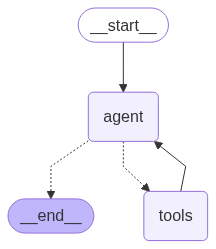

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
inputs = {"messages": [("user", "where do lions live")]}
final = ""
for chunk, value in graph.stream(inputs, config=config ,stream_mode="messages"):
    if chunk.content:
        final += chunk.content

print(final)

        




DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/chat/completions', 'headers': {'api-key': '<redacted>'}, 'files': None, 'idempotency_key': 'stainless-python-retry-bb38f57e-d20d-4be5-b019-3ba119e9735c', 'json_data': {'messages': [{'content': 'You are a mechanical maintenance assistant. \n\nRespond in a helpful, expert, friendly, professional manner.\nAlways answer the MOST RECENT user message; use prior turns for context. \n\n \n    TOOLS:\n    ------\n\n    You have access to the following tools:\n\n    [\'tool_troubleshoot\', \'tool_find_drawing\', \'tool_get_drawing_urls\']\n\n    "- DRAWINGS: Call tool_find_drawing first; if it returns pages, then call tool_get_drawing_urls.\n"\n    "- TROUBLESHOOT: Call tool_troubleshoot to get relevant documents for any troubleshooting query.\n"\n\n    To use a tool, please use the following format:\n\n    ```\n    Thought: Do I need to use a tool? Yes\n    Action: the action to take, should be one of [[\'tool_troubleshoot\'

Lions primarily live in **grasslands, savannas, and open woodlands**. They are most commonly found in sub-Saharan Africa, where they inhabit regions with plenty of prey and access to water. A small population of Asiatic lions also exists in the **Gir Forest National Park** in Gujarat, India.

These habitats provide the open spaces lions need for hunting and the shade of trees or bushes for resting during the heat of the day. Let me know if you'd like more details about their environment or behavior!


In [22]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='how to troubleshoot servo valve and show me a drawing of it.', additional_kwargs={}, response_metadata={}, id='3177b55c-6e1a-466f-a9c5-07de4c88e019'), AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_ODTZ2LZjZytxhlTmZgkTuUTj', 'function': {'arguments': '{"query": "how to troubleshoot a servo valve"}', 'name': 'tool_troubleshoot'}, 'type': 'function'}, {'index': 1, 'id': 'call_2IyZ6FTY4aL3J1kCeQVF2DvT', 'function': {'arguments': '{"query": "servo valve drawing"}', 'name': 'tool_find_drawing'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_3eed281ddb'}, id='run--d8faabc7-9e4a-452f-a584-b2ec3a74b320-0', tool_calls=[{'name': 'tool_troubleshoot', 'args': {'query': 'how to troubleshoot a servo valve'}, 'id': 'call_ODTZ2LZjZytxhlTmZgkTuUTj', 'type': 'tool_call'}, {'name': 'tool_find_drawing', 'args': {'query': 'servo v